In [1]:
import sys
sys.path.append('..')
from src.agents import QAgent

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

[Warning] milp library not available, LP solvers will be disabled.


/home/rando/anaconda3/envs/olfactory_navigation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

In [3]:
from src import Environment

In [4]:
data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH

env = Environment(data=data_path,
                  source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='no',
                  start_zone='odor_present',
                  odor_present_treshold=3e-6)

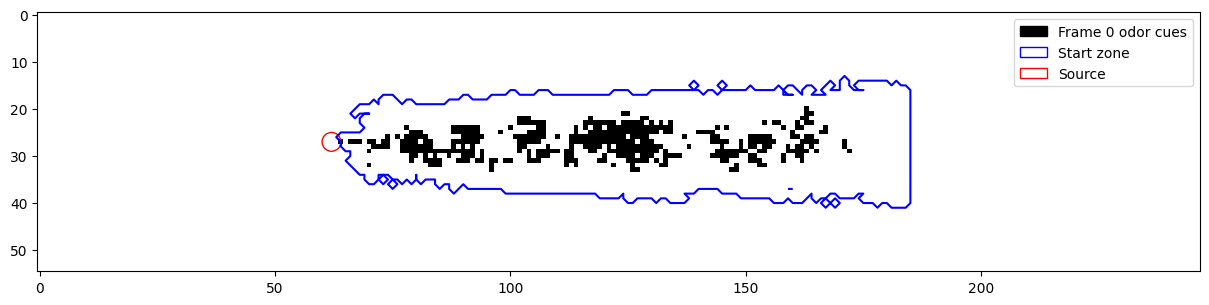

In [5]:
env.plot()

In [7]:
memory_size = 10
time_disc = 500
horizon = 1000
num_episodes=100000#50000
delta = 500
gamma = 1.0
eps_decay = 0.0001
alpha_decay = 0.00001
eps = lambda t : 0.9 * np.exp(-eps_decay * t)  #if np.exp(-eps_decay * t)  > 0.3 else 0.3
alpha = lambda t : 0.5 * np.exp(-alpha_decay * t) # if np.exp(-alpha_decay * t) > 0.0001 else 0.0001 #0.3 * np.exp(-alpha_decay * t) > 0.001 else 0.001

checkpoint_folder = "./q_agent_training/checkpoints_4"
checkpoint_frequency = 5000


ag = QAgent(env, 
            memory_size=memory_size, 
            treshold=3e-6,
            time_disc=time_disc, 
            horizon=horizon,
            num_episodes=num_episodes,
            delta=delta,
            eps_greedy= eps,
            learning_rate=alpha,
            gamma = gamma,
            seed=13141516,
            checkpoint_folder=checkpoint_folder,
            checkpoint_frequency=checkpoint_frequency
            )

In [8]:
np.random.seed(121314)
training_result = ag.train()


100%|██████████| 100000/100000 [21:21<00:00, 78.06it/s, episode=1e+5, init_pos=[ 30 161], init time slice=1907, avg R_t=0.994, eps=4.085993678623637e-05, alpha=0.2575156088200096]   


In [9]:
ag.Q

array([[367.24027507,   0.        ,   0.        ,   0.        ],
       [366.45140168, 349.76591446, 350.67464089, 350.45769149],
       [366.49562761, 352.40840379, 357.64575295, 350.80146561],
       ...,
       [324.8036116 , 322.37398088, 367.00013933, 323.53057097],
       [322.26777988, 322.97132227, 366.87736027, 326.69368232],
       [366.78293805, 325.81348476, 329.69559578, 326.78575231]])

[0. 0.] [ 0. -1.]
[ 0. -1.] [ 0. -2.]
[ 0. -2.] [ 0. -3.]
[ 0. -3.] [ 1. -3.]
[ 1. -3.] [ 2. -3.]
[ 2. -3.] [ 2. -4.]
[ 2. -4.] [ 2. -5.]
[ 2. -5.] [ 3. -5.]
[ 3. -5.] [ 2. -5.]
[ 2. -5.] [ 2. -6.]
[ 2. -6.] [ 2. -5.]
[ 2. -5.] [ 1. -5.]
[ 1. -5.] [ 1. -6.]
[ 1. -6.] [ 0. -6.]
[ 0. -6.] [ 0. -5.]
[ 0. -5.] [-1. -5.]
[-1. -5.] [-2. -5.]
[-2. -5.] [-1. -5.]
[-1. -5.] [-1. -4.]
[-1. -4.] [ 0. -4.]
[ 0. -4.] [ 0. -5.]
[ 0. -5.] [-1. -5.]
[-1. -5.] [-2. -5.]
[-2. -5.] [-2. -4.]
[-2. -4.] [-3. -4.]
[-3. -4.] [-2. -4.]
[-2. -4.] [-3. -4.]
[-3. -4.] [-3. -3.]
[-3. -3.] [-3. -4.]
[-3. -4.] [-3. -3.]
[-3. -3.] [-3. -2.]
[-3. -2.] [-3. -3.]
[-3. -3.] [-3. -2.]
[-3. -2.] [-3. -1.]
[-3. -1.] [-4. -1.]
[-4. -1.] [-4. -2.]
[-4. -2.] [-5. -2.]
[-5. -2.] [-4. -2.]
[-4. -2.] [-4. -3.]
[-4. -3.] [-4. -2.]
[-4. -2.] [-3. -2.]
[-3. -2.] [-3. -3.]
[-3. -3.] [-3. -2.]
[-3. -2.] [-3. -1.]
[-3. -1.] [-2. -1.]
[-2. -1.] [-2. -2.]
[-2. -2.] [-1. -2.]
[-1. -2.] [-1. -1.]
[-1. -1.] [-2. -1.]
[-2. -1.] [-2. -2.]


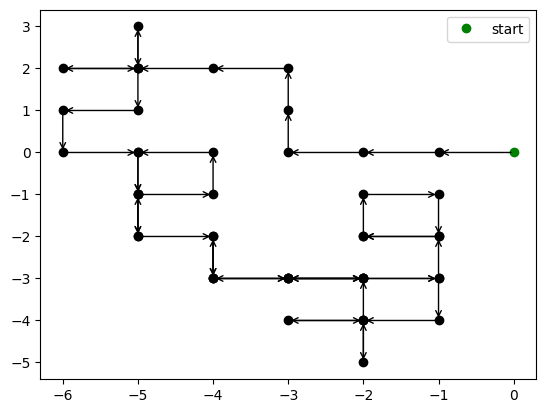

In [12]:
pos = np.array([0.0, 0.0])
fig, ax = plt.subplots()
for i in range(50):
    next_pos = pos + ag.action_set[ag.Q[i, :].argmax()]
    print(pos, next_pos)
#    print("[--] state = {}\taction = {}".format(i, ag.Q[i, :].argmax()))
    ax.plot(next_pos[1], next_pos[0], 'o', c='black')
    ax.annotate("", xy=(next_pos[1], next_pos[0]), xytext=(pos[1], pos[0]), arrowprops=dict(arrowstyle='->', color='black'))
    pos = next_pos
ax.plot(0.0, 0.0, 'o', c='green', label='start')
ax.legend()

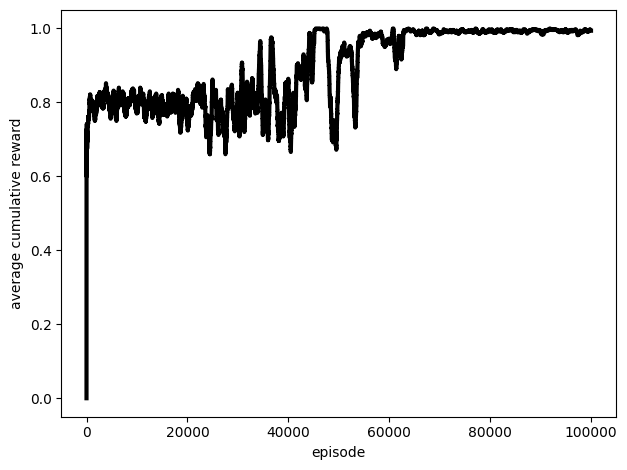

In [13]:
average_cumulative_reward = training_result['average_cumulative_reward']

fig, ax = plt.subplots()

ax.plot(range(average_cumulative_reward.shape[0]), average_cumulative_reward, '-', lw=3, c='black')

ax.set_xlabel("episode")
ax.set_ylabel("average cumulative reward")

fig.tight_layout()
fig.savefig("./training_result.pdf", bbox_inches='tight')

In [27]:
(ag.Q.argmax(axis=1) == 2).sum(), (ag.Q.argmax(axis=1) == 3).sum()

(25, 29)

In [14]:
ag.deterministic = True

In [ ]:
#ag.save("./")

In [104]:
ag.load(".")

In [15]:
from src.simulation import run_test

histories = {i:None for i in [0, 100, 1000, 2000, 2400]}
for time_shift in histories.keys():
    print(f"[--] Time shift = {time_shift}")
    histories[time_shift] = run_test(n=100000, agent=ag, horizon=1000, time_shift=time_shift,  use_gpu=False)

[--] Time shift = 0


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 238.74it/s, done =98480 of 100000 (98.5%)]


Simulations done in 4.191s:
Simulations reached goal: 98480/100000 (1520 failures) (98.48%)
	- Average step count: 147.17638 (Successfull only: 134.01338342810723)
	- Extra steps: 76.22483 (Successful only: 63.388139723801785)
	- Average discounted rewards (ADR): 0.352 (Successfull only: 0.357) (discount: 0.99)
	- Tmin/T: 0.658 (Successful only: 0.667)
[--] Time shift = 100


100%|██████████| 1000/1000 [00:04<00:00, 246.51it/s, done =99406 of 100000 (99.4%)]


Simulations done in 4.058s:
Simulations reached goal: 99406/100000 (594 failures) (99.41%)
	- Average step count: 141.21146 (Successfull only: 136.07977385670884)
	- Extra steps: 70.08504 (Successful only: 65.13105848741525)
	- Average discounted rewards (ADR): 0.350 (Successfull only: 0.352) (discount: 0.99)
	- Tmin/T: 0.653 (Successful only: 0.657)
[--] Time shift = 1000


100%|██████████| 1000/1000 [00:04<00:00, 231.18it/s, done =97788 of 100000 (97.8%)]


Simulations done in 4.327s:
Simulations reached goal: 97788/100000 (2212 failures) (97.79%)
	- Average step count: 154.19084 (Successfull only: 135.05833026547225)
	- Extra steps: 82.97649 (Successful only: 63.15666543952223)
	- Average discounted rewards (ADR): 0.338 (Successfull only: 0.346) (discount: 0.99)
	- Tmin/T: 0.647 (Successful only: 0.661)
[--] Time shift = 2000


 60%|█████▉    | 597/1000 [00:03<00:02, 176.05it/s, done =98608 of 100000 (98.6%)]


Simulations done in 3.393s:
Simulations reached goal: 98608/100000 (1392 failures) (98.61%)
	- Average step count: 135.5113 (Successfull only: 128.98257747850073)
	- Extra steps: 64.35253 (Successful only: 57.540057601817296)
	- Average discounted rewards (ADR): 0.354 (Successfull only: 0.359) (discount: 0.99)
	- Tmin/T: 0.667 (Successful only: 0.675)
[--] Time shift = 2400


 20%|█▉        | 197/1000 [00:02<00:10, 79.13it/s, done =77572 of 100000 (77.6%)] 


Simulations done in 2.491s:
Simulations reached goal: 77572/100000 (22428 failures) (77.57%)
	- Average step count: 120.80157 (Successfull only: 98.48157840457897)
	- Extra steps: 49.6427 (Successful only: 33.74024132418914)
	- Average discounted rewards (ADR): 0.357 (Successfull only: 0.420) (discount: 0.99)
	- Tmin/T: 0.670 (Successful only: 0.727)


In [9]:
hist.save()

Simulations saved to: ./Simulations-s_55_247-n_10000-horizon_198-04182024_110753.csv


In [16]:
hist.plot(14)

NameError: name 'hist' is not defined

In [ ]:
ag.Q[0, :]

array([133.77937272, 133.71913402, 133.71757199, 133.72083726])